* https://nycdatascience.com/blog/student-works/kaggles-advanced-regression-competition-predicting-housing-prices-in-ames-iowa/
* https://www.kaggle.com/echooooo/feature-engineering-for-ames-home-prices/code
* https://www.kaggle.com/jdunavin/predicting-house-prices-in-ames-iowa/code
* https://blog.akquinet.de/2017/09/19/predicting-house-prices-on-kaggle-part-i/ - Gentle introduction

Plan
===
* Load train/test data
* Adjust target distribution
* Univariate analysis
* Omit highly correlated features
* Omit outlier samples
* Handle missing values
* Create model Pipeline
* Train model
* Visualize prediction accuracy
* Submit predictions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Load train/test data
===

In [120]:
data_train = pd.read_csv('data/train.csv', index_col="Id")
data_test = pd.read_csv('data/test.csv', index_col="Id")
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

Adjust Target Distribution
===

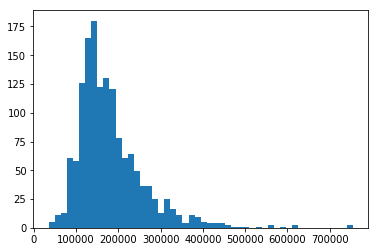

In [121]:
plt.hist(data_train.SalePrice, bins = 50);

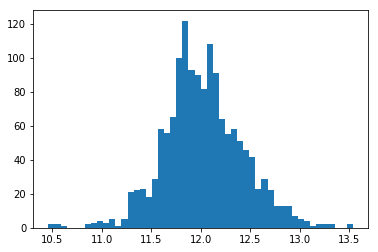

In [122]:
plt.hist(np.log(data_train.SalePrice), bins = 50);

In [123]:
data_train.SalePrice = np.log1p(data_train.SalePrice)

Univariate Analysis
===

In [124]:
nominal_features = [
    'MSSubClass', 'MSZoning', 
    'Street', 'Alley',
    'Utilities', 'LotConfig', 
    'Neighborhood', 'Condition1',
    'Condition2', 'BldgType', 
    'HouseStyle', 'RoofStyle',
    'RoofMatl', 'Exterior1st', 
    'Exterior2nd', 'MasVnrType',
    'Foundation', 'Heating', 
    'CentralAir', 'GarageType',
    'MiscFeature', 'SaleType', 
    'SaleCondition'
]

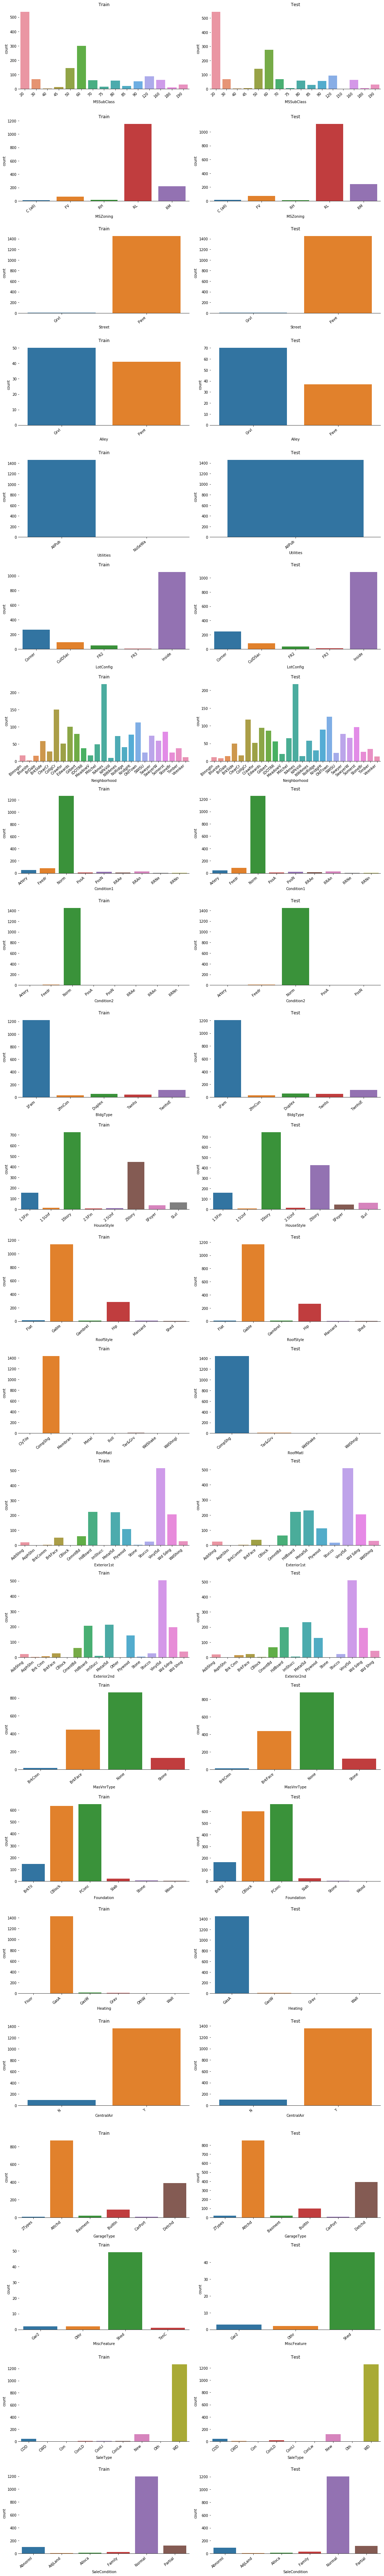

In [125]:
fig, axes = plt.subplots(nrows=23, ncols=2, figsize=(15,100), sharex=False, sharey=False)
sns.despine(left=True)
for i in range(0, len(nominal_features)):
    nominal_feature_train = data_train[nominal_features[i]]
    nominal_feature_test = data_test[nominal_features[i]]
    
    axis_train = axes[i, 0]
    axis_test = axes[i, 1]
    
    axis_train.set_xticklabels(axis_train.get_xticklabels(), rotation=40, ha="right")
    axis_test.set_xticklabels(axis_test.get_xticklabels(), rotation=40, ha="right")
    
    sns.countplot(nominal_feature_train.sort_values(), ax=axis_train).set_title('Train')
    sns.countplot(nominal_feature_test.sort_values(), ax=axis_test).set_title('Test')

plt.tight_layout()

Bivariate Analysis
===

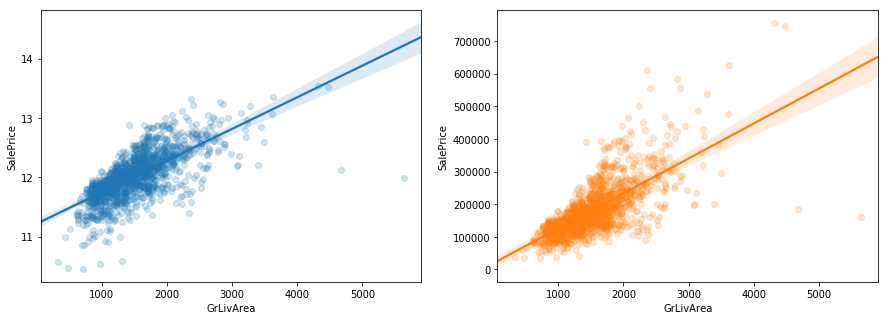

In [126]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=False, sharey=False)
sns.regplot(x=data_train.GrLivArea, y=data_train.SalePrice, ax=axes[0], scatter_kws={'alpha':0.2})
sns.regplot(x=data_train.GrLivArea, y=np.expm1(data_train.SalePrice), ax=axes[1], scatter_kws={'alpha':0.2})

In [127]:
adj_data_train = data_train.loc[data_train.GrLivArea < 4000]

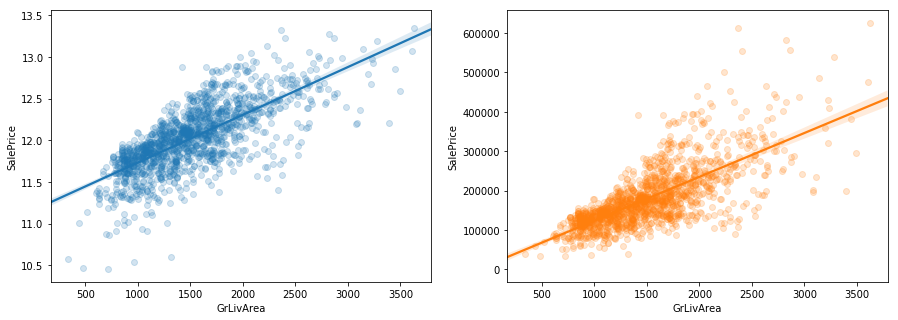

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharex=False, sharey=False)
sns.regplot(x=adj_data_train.GrLivArea, y=adj_data_train.SalePrice, ax=axes[0], scatter_kws={'alpha':0.2})
sns.regplot(x=adj_data_train.GrLivArea, y=np.expm1(adj_data_train.SalePrice), ax=axes[1], scatter_kws={'alpha':0.2})

Omit Highly Correlated Features
===

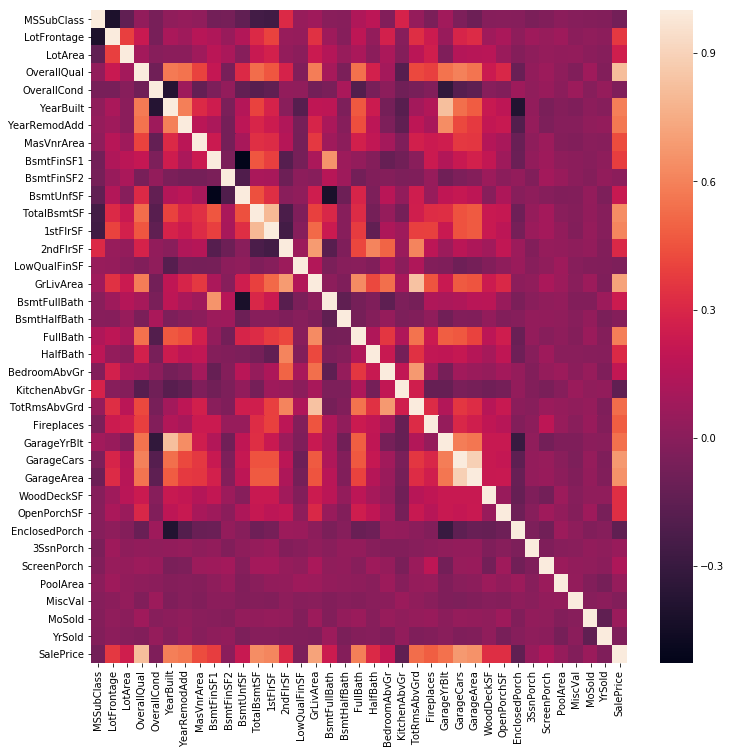

In [129]:
plt.subplots(figsize=(12,12))
sns.heatmap(adj_data_train.corr(), 
            xticklabels=adj_data_train.corr().columns.values,
            yticklabels=adj_data_train.corr().columns.values);

In [130]:
drop_columns=['GarageCars', 'GarageYrBlt', 'TotRmsAbvGrd', 'TotalBsmtSF']
adj_data_train = adj_data_train.drop(columns=drop_columns)
adj_data_test = data_test.drop(columns=drop_columns)

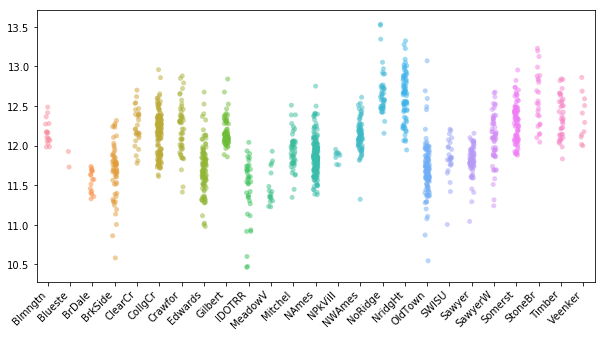

In [70]:
plt.subplots(figsize=(10,5))
ax = sns.stripplot(x=data_train.Neighborhood.values, 
              y=np.log(data_train.SalePrice.values),
              order=np.sort(data_train.Neighborhood.unique()),
              jitter=0.1,
              alpha=0.5);
plt.xticks(rotation=45, ha="right");

In [69]:
ordered_neighborhoods = data_train.groupby('Neighborhood')['SalePrice'].mean().sort_values()

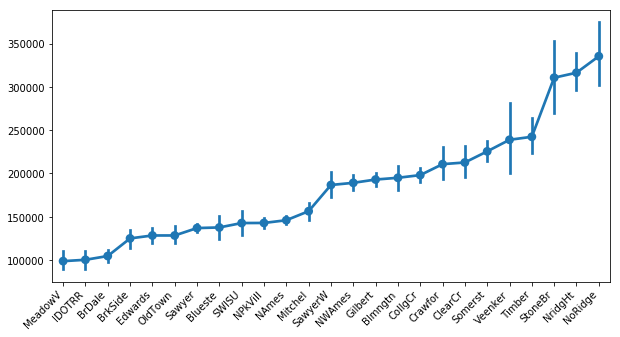

In [68]:
plt.subplots(figsize=(10,5))
ax = sns.pointplot(x=data_train.Neighborhood.values, 
              y=data_train.SalePrice.values,
              order=ordered_neighborhoods.index);
plt.xticks(rotation=45, ha="right");

Create Pipeline
===

In [112]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import TransformerMixin
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

In [113]:
class ColumnSelectTransformer(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X[self.columns]
    
class FillNaTransformer(TransformerMixin):
    def __init__(self, fill_with):
        self.fill_with = fill_with
        
    def fit(self, X, y, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X.fillna(self.fill_with)
    
class ToDictTransformer(TransformerMixin):

    def fit(self, *_):
        return self

    def transform(self, X, **transform_params):
        return X.to_dict(orient='records')
    
def nominal_feature(name, fill_with='None'):
    return (name, Pipeline([
        ('extract', ColumnSelectTransformer([name])),
        ('fill_na', FillNaTransformer(fill_with)),
        ('to_dict', ToDictTransformer()),
        ('label', DictVectorizer(sparse=False))
    ]))

def ordinal_feature(name, fill_with='None'):
    return (name, Pipeline([
        ('extract', ColumnSelectTransformer([name])),
        ('fill_na', FillNaTransformer(fill_with)),
        ('to_dict', ToDictTransformer()),
        ('label', DictVectorizer(sparse=False))
    ]))

def continuous_feature(name, fill_with=0.0):
    return (name, Pipeline([
        ('extract', ColumnSelectTransformer([name])),
        ('fill_na', FillNaTransformer(fill_with))
    ]))

def discrete_feature(name, fill_with=0.0):
    return (name, Pipeline([
        ('extract', ColumnSelectTransformer([name])),
        ('fill_na', FillNaTransformer(fill_with))
    ]))
    
def create_pipeline():
    pipeline = Pipeline([
        ('features', FeatureUnion([
            nominal_feature('MSSubClass'),
            nominal_feature('MSZoning'),         
            continuous_feature('LotFrontage'),
            continuous_feature('LotArea'),
            nominal_feature('Street'),
            nominal_feature('Alley'),
            ordinal_feature('LotShape'),
            nominal_feature('LandContour'),
            ordinal_feature('Utilities'),
            nominal_feature('LotConfig'),
            ordinal_feature('LandSlope'),
            nominal_feature('Neighborhood'),
            nominal_feature('Condition1'),
            nominal_feature('Condition2'),
            nominal_feature('BldgType'),
            nominal_feature('HouseStyle'),
            ordinal_feature('OverallQual'),
            ordinal_feature('OverallCond'),
            discrete_feature('YearBuilt'),
            discrete_feature('YearRemodAdd'),
            nominal_feature('RoofStyle'),
            nominal_feature('RoofMatl'),
            nominal_feature('Exterior1st'),
            nominal_feature('Exterior2nd'),
            nominal_feature('MasVnrType'),
            continuous_feature('MasVnrArea'),
            ordinal_feature('ExterQual'),
            ordinal_feature('ExterCond'),
            nominal_feature('Foundation'),
            ordinal_feature('BsmtQual'),
            ordinal_feature('BsmtCond'),
            ordinal_feature('BsmtExposure'),
            ordinal_feature('BsmtFinType1'),
            continuous_feature('BsmtFinSF1'),
            ordinal_feature('BsmtFinType2'),
            continuous_feature('BsmtFinSF2'),
            continuous_feature('BsmtUnfSF'),
            nominal_feature('Heating'),
            ordinal_feature('HeatingQC'),
            nominal_feature('CentralAir'),
            ordinal_feature('Electrical'),
            continuous_feature('1stFlrSF'),
            continuous_feature('2ndFlrSF'),
            continuous_feature('LowQualFinSF'),
            continuous_feature('GrLivArea'),
            discrete_feature('BsmtFullBath'),
            discrete_feature('BsmtHalfBath'),
            discrete_feature('FullBath'),
            discrete_feature('HalfBath'),  
            discrete_feature('BedroomAbvGr'),
            discrete_feature('KitchenAbvGr'),
            ordinal_feature('KitchenQual'),
            ordinal_feature('Functional'),
            discrete_feature('Fireplaces'),
            ordinal_feature('FireplaceQu'),
            nominal_feature('GarageType'),
            ordinal_feature('GarageFinish'),
            continuous_feature('GarageArea'),  
            ordinal_feature('GarageQual'),
            ordinal_feature('GarageCond'),
            ordinal_feature('PavedDrive'),
            continuous_feature('WoodDeckSF'),
            continuous_feature('OpenPorchSF'),
            continuous_feature('EnclosedPorch'),
            continuous_feature('3SsnPorch'), 
            continuous_feature('ScreenPorch'),
            continuous_feature('PoolArea'),
            ordinal_feature('PoolQC'),
            ordinal_feature('Fence'),
            nominal_feature('MiscFeature'),
            continuous_feature('MiscVal'),
            discrete_feature('MoSold'),
            discrete_feature('YrSold'),
            nominal_feature('SaleType'),
            nominal_feature('SaleCondition')
        ])),
        ('regressor', GradientBoostingRegressor())
    ])
    return pipeline

In [115]:
kfold = KFold(5)
np.random.seed(0)
rmses = []

model = create_pipeline()
for (train_idx, cv_idx) in kfold.split(adj_data_train):
    train = adj_data_train.iloc[train_idx]
    validate = adj_data_train.iloc[cv_idx]

    train_X = train.drop(columns=['SalePrice'])
    train_y = train['SalePrice']

    validate_X = validate.drop(columns=['SalePrice'])
    validate_y = validate['SalePrice']

    model.fit(train_X, y=train_y)
    predictions = model.predict(validate_X)
    rmse = np.sqrt(mean_squared_error(np.expm1(validate_y), np.expm1(predictions)))
    rmses.append(rmse)
    print(rmse)

print('mean', np.mean(rmses), '\n')

21975.70007502369
23503.589213719413
25836.608166706985
19893.552406889616
23455.504025389822
mean 22932.990777545907 



In [141]:
copy_data_test = adj_data_test
copy_data_test['LogSalePrice'] = model.predict(copy_data_test)
copy_data_test['SalePrice'] = np.expm1(copy_data_test['LogSalePrice'])
copy_data_test['SalePrice'].to_csv('predictions.csv')